<b style='font-size:2em'>Tutorial 2 – Solving pre-defined partial differential equations</b>

This second part of the tutorial dives into actual partial differential equations.

In [1]:
# import packages
import sys
import numpy as np
import pde

## Simple interface for solving PDEs

In the simplest case, a PDE evolves a field in time. To reflect this in code, we first define an initial state and then use a simple PDE to evolve it in time.

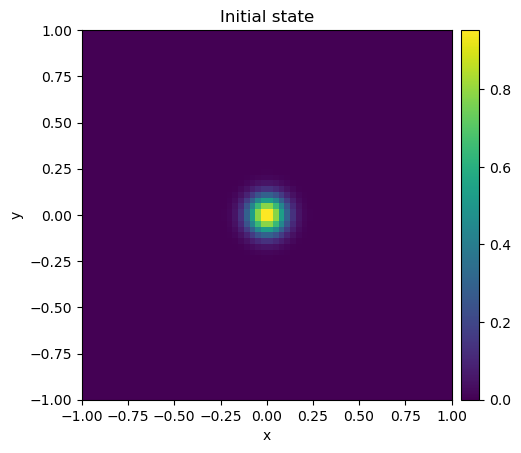

In [2]:
grid = pde.CartesianGrid([[-1, 1], [-1, 1]], 64)
state = pde.ScalarField.from_expression(grid, "exp(-(x**2 + y**2) * 100)")
state.plot(title="Initial state");

  0%|          | 0/1.0 [00:00<?, ?it/s]

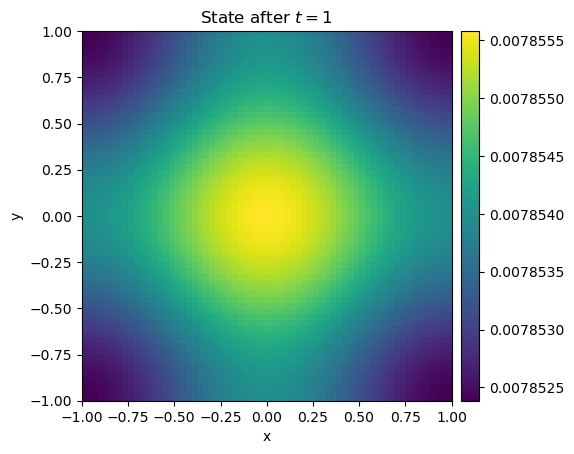

In [3]:
eq = pde.DiffusionPDE()
result = eq.solve(state, t_range=1, dt=1e-6)
result.plot(title="State after $t=1$");

Other PDEs can be solved similarly, but might require different initial conditions and/or solution parameters (e.g., `dt`).

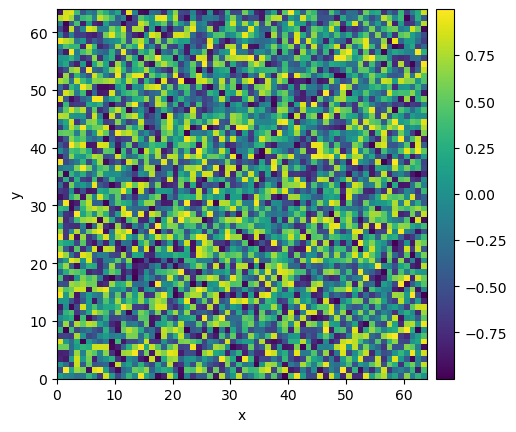

  0%|          | 0/100.0 [00:00<?, ?it/s]

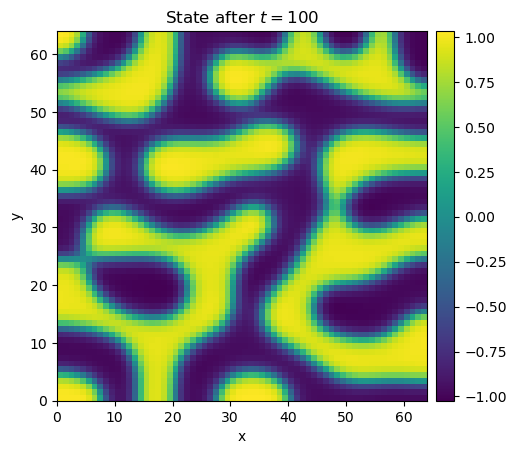

In [4]:
grid = pde.UnitGrid([64, 64])
state = pde.ScalarField.random_uniform(grid, -1, 1)

state.plot()

eq = pde.CahnHilliardPDE()
result = eq.solve(state, t_range=1e2, dt=1e-3)
result.plot(title="State after $t=100$", colorbar=True);

The boundary conditions applied to the differential operators of the PDE are usually specified as attributes of the PDE class.

  0%|          | 0/10.0 [00:00<?, ?it/s]

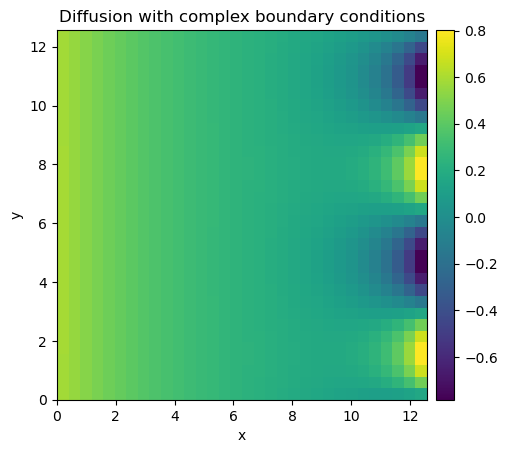

In [5]:
grid = pde.CartesianGrid(
    [[0, 4 * np.pi], [0, 4 * np.pi]], [32, 32], periodic=[False, True]
)
state = pde.ScalarField.random_uniform(grid, 0.2, 0.3)

# set boundary conditions `bc` for all axes
bc_x_left = {"derivative": 0.1}
bc_x_right = {"value": "sin(y)"}
bc_x = [bc_x_left, bc_x_right]
bc_y = "periodic"
eq = pde.DiffusionPDE(bc=[bc_x, bc_y])

result = eq.solve(state, t_range=10, dt=0.005)
result.plot(title="Diffusion with complex boundary conditions");

PDEs can also be solved on grids enforcing symmetries.

  0%|          | 0/0.1 [00:00<?, ?it/s]

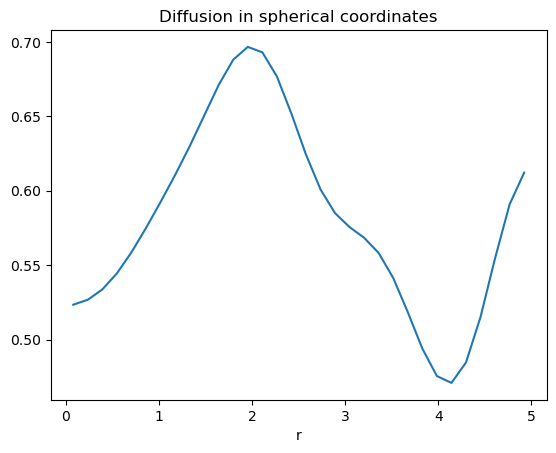

In [6]:
grid = pde.SphericalSymGrid([0, 5], 32)
state = pde.ScalarField.random_uniform(grid)

eq = pde.DiffusionPDE()
result = eq.solve(state, t_range=0.1, dt=0.005)
result.plot(title="Diffusion in spherical coordinates");

## Trackers

Trackers provide a way to access, analyze, and store information during the evolution of a PDE.

In [7]:
grid = pde.UnitGrid([128, 128])
state = pde.ScalarField.random_uniform(grid, -0.5, 0.5)
eq = pde.CahnHilliardPDE()

In [8]:
# Show the evolution while computing it
eq.solve(state, t_range=1e3, dt=0.01, tracker=pde.PlotTracker(interrupts=100));

Output()

In [9]:
# reduced output
trackers = [
    "progress",
    pde.PrintTracker(interrupts="0:01"),  # print output roughly every real second
]

eq.solve(state, t_range=1e3, dt=0.01, tracker=trackers);

  0%|          | 0/1000.0 [00:00<?, ?it/s]

t=0, c=0.00127±0.289
t=0.02, c=0.00127±0.219
t=0.1, c=0.00127±0.147
t=1.93, c=0.00127±0.117
t=17.23, c=0.00127±0.545
t=65.39, c=0.00127±0.732
t=151.54, c=0.00127±0.8
t=264.87, c=0.00127±0.829
t=396.59, c=0.00127±0.85
t=539.43, c=0.00127±0.862
t=688.4, c=0.00127±0.872
t=840.31, c=0.00127±0.88
t=993.5, c=0.00127±0.885


Data can also be stored in memory and in files

In [10]:
storage = pde.MemoryStorage()
eq.solve(state, 100, dt=0.01, tracker=storage.tracker(interrupts=10))

for field in storage:
    print(f"{field.integral:.3g}, {field.fluctuations:.3g}")

20.7, 0.289
20.7, 0.365
20.7, 0.579
20.7, 0.646
20.7, 0.681
20.7, 0.705
20.7, 0.723
20.7, 0.739
20.7, 0.752
20.7, 0.762
20.7, 0.77


In [11]:
storage_write = pde.FileStorage("simulation.hdf")
eq.solve(state, 100, dt=0.01, tracker=storage_write.tracker(interrupts=10));

In [12]:
storage_read = pde.FileStorage("simulation.hdf")
for field in storage_read:
    print(f"{field.integral:.3g}, {field.fluctuations:.3g}")

20.7, 0.289
20.7, 0.365
20.7, 0.579
20.7, 0.646
20.7, 0.681
20.7, 0.705
20.7, 0.723
20.7, 0.739
20.7, 0.752
20.7, 0.762
20.7, 0.77


## Stochastic simulations

Some PDE classes support stochastic simulations. Here, a noise term is added to the evolution rate of the PDE. This noise term is interpreted in the Itô interpretation and the standard PDE classes only support additive noise.

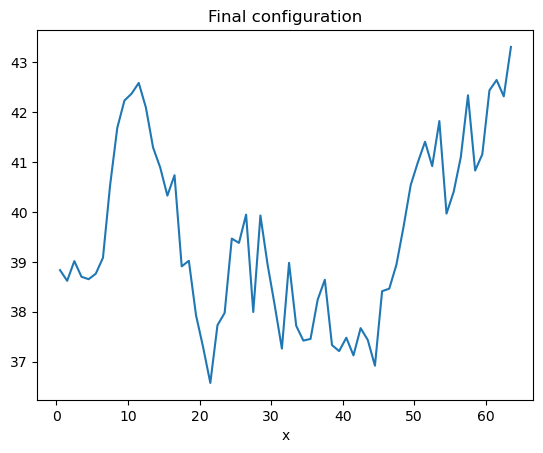

In [13]:
grid = pde.UnitGrid([64])
state = pde.ScalarField.random_harmonic(grid)

eq = pde.KPZInterfacePDE(noise=1)
storage = pde.MemoryStorage()
result = eq.solve(state, t_range=100, dt=0.01, tracker=storage.tracker(1))
result.plot(title="Final configuration");

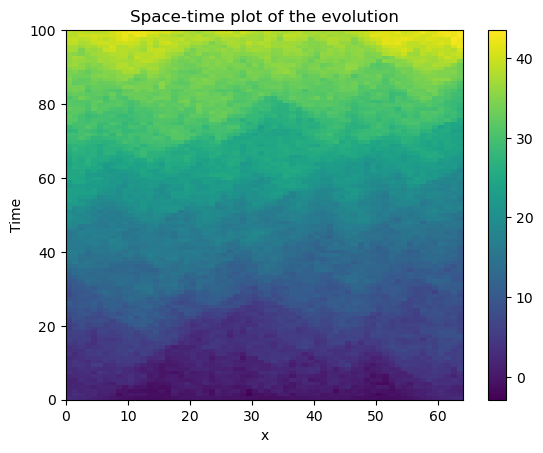

In [14]:
pde.plot_kymograph(storage, title="Space-time plot of the evolution");

## Poisson's and Laplace's equation
Beside solving for the time evolution of typical partial differential equations, we can also solve Poisson's and Laplace's problem, $\nabla^2 u = -f$, where $f=0$ in the Laplace case.

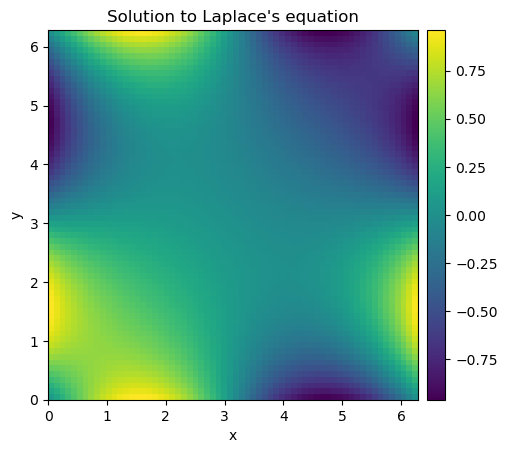

In [15]:
grid = pde.CartesianGrid([[0, 2 * np.pi]] * 2, 64)
bcs = [{"value": "sin(y)"}, {"value": "sin(x)"}]

field_zero = pde.ScalarField(grid)
result_laplace = pde.solve_poisson_equation(field_zero, bc=bcs)
result_laplace.plot(title="Solution to Laplace's equation", colorbar=True);

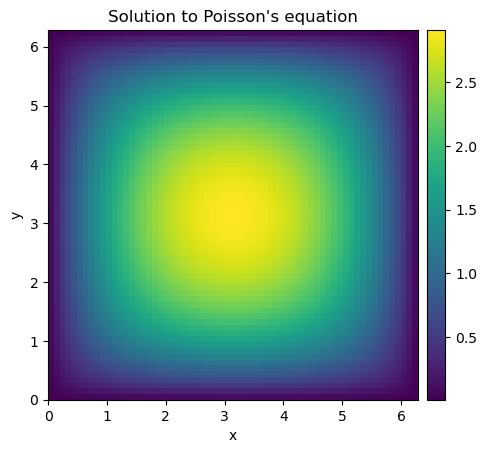

In [16]:
field_one = pde.ScalarField(grid, -1)
result_poisson = pde.solve_poisson_equation(field_one, bc={"value": "0"})
result_poisson.plot(colorbar=True);

In [17]:
result_poisson.laplace(bc={"value": "0"})

ScalarField(grid=CartesianGrid(bounds=((0.0, 6.283185307179586), (0.0, 6.283185307179586)), shape=(64, 64), periodic=[False, False]), data=[[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]])

## User defined PDEs
Custom PDEs can be defined using all the machinery exposed by the package.

  0%|          | 0/10.0 [00:00<?, ?it/s]

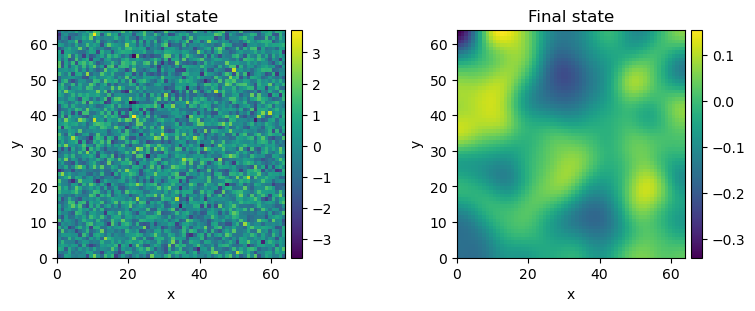

In [18]:
# define a simple diffusion equation
eq = pde.PDE({"u": "laplace(u)"})

# initialize state
grid = pde.UnitGrid([64, 64])
state = pde.ScalarField.random_normal(grid, label="Initial state")

# simulate the pde
sol = eq.solve(state, t_range=10, dt=1e-2)
sol.label = "Final state"

# compare the initial and final state
pde.FieldCollection([state, sol]).plot();

The `PDE` class also supports multiple fields and vectorial PDEs.

In [19]:
# define the Brusselator PDE
a, b = 1, 3
d0, d1 = 1, 0.1
eq = pde.PDE(
    {
        "u": f"{d0} * laplace(u) + {a} - ({b} + 1) * u + u**2 * v",
        "v": f"{d1} * laplace(v) + {b} * u - u**2 * v",
    }
)

# initialize state
grid = pde.UnitGrid([64, 64])
u = pde.ScalarField(grid, a, label="Field $u$")
v = b / a + 0.1 * pde.ScalarField.random_normal(grid, label="Field $v$")
state = pde.FieldCollection([u, v])

# simulate the pde
sol = eq.solve(state, t_range=20, dt=1e-3, tracker=pde.PlotTracker())

Output()

Spent more time on handling trackers (29) than on the actual simulation (12.6)


The `PDE` class allows a straight-forward implementation of simple PDEs. If more control is necessary, `PDEBase` can be subclasses.

  0%|          | 0/10.0 [00:00<?, ?it/s]

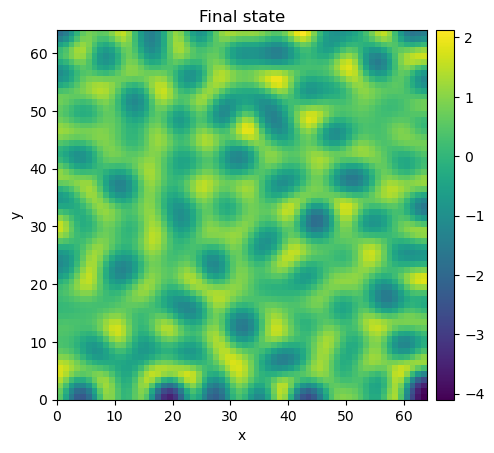

In [20]:
class KuramotoSivashinskyPDE(pde.PDEBase):
    """Implementation of the normalized Kuramoto–Sivashinsky equation"""

    def evolution_rate(self, state, t=0):
        """implement the python version of the evolution equation"""
        state_lap = state.laplace(bc="natural")
        state_lap2 = state_lap.laplace(bc="natural")
        state_grad = state.gradient(bc="natural")
        return -state_grad.to_scalar("squared_sum") / 2 - state_lap - state_lap2


grid = pde.UnitGrid([64, 64])
state = pde.ScalarField.random_uniform(grid)

eq = KuramotoSivashinskyPDE()
result = eq.solve(state, t_range=10, dt=0.01)
result.plot(title="Final state");

## Advanced interface for solving PDEs

In [21]:
from pprint import pprint

In [22]:
# initialize the grid, an initial condition, and the PDE
grid = pde.UnitGrid([32, 32])
field = pde.ScalarField.random_uniform(grid, -1, 1)
eq = pde.DiffusionPDE()

In [23]:
# try the explicit solver
solver1 = pde.ExplicitSolver(eq)
controller1 = pde.Controller(solver1, t_range=1, tracker=None)
sol1 = controller1.run(field, dt=1e-3)
sol1.label = "py-pde"
pprint(controller1.diagnostics)

{'controller': {'jit_count': {'make_stepper': 11, 'simulation': 0},
                'process_count': 1,
                'profiler': {'compilation': 2.7167049999999904,
                             'solver': 0.03407699999999636,
                             'tracker': 4.500000000007276e-05},
                'solver_duration': '0:00:00.034097',
                'solver_start': '2024-09-28 10:42:33.117268',
                'stop_reason': 'Reached final time',
                'successful': True,
                't_end': 1.0,
                't_final': 1.0,
                't_start': 0},
 'package_version': '0.40.0',
 'solver': {'backend': 'numba',
            'class': 'ExplicitSolver',
            'dt': 0.001,
            'pde_class': 'DiffusionPDE',
            'scheme': 'euler',
            'state_modifications': 0.0,
            'steps': 1000,
            'stochastic': False}}


In [24]:
# try the standard scipy solver
solver2 = pde.ScipySolver(eq)
controller2 = pde.Controller(solver2, t_range=1, tracker=None)
sol2 = controller2.run(field)
sol2.label = "scipy"
pprint(controller2.diagnostics)

{'controller': {'jit_count': {'make_stepper': 1, 'simulation': 0},
                'process_count': 1,
                'profiler': {'compilation': 0.38731899999999087,
                             'solver': 0.0022289999999998145,
                             'tracker': 3.399999999942338e-05},
                'solver_duration': '0:00:00.003989',
                'solver_start': '2024-09-28 10:42:39.050074',
                'stop_reason': 'Reached final time',
                'successful': True,
                't_end': 1.0,
                't_final': 1.0,
                't_start': 0},
 'package_version': '0.40.0',
 'solver': {'backend': 'numba',
            'class': 'ScipySolver',
            'dt': None,
            'pde_class': 'DiffusionPDE',
            'steps': 50,
            'stochastic': False}}


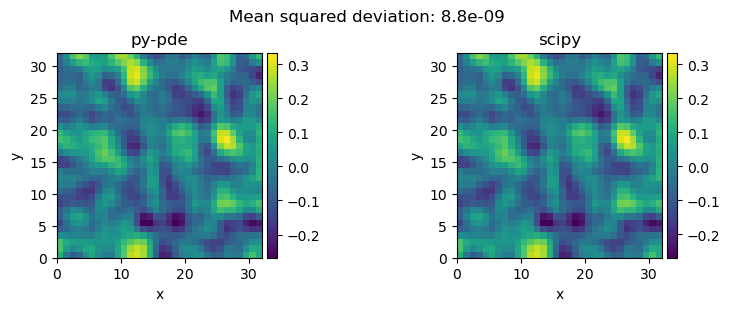

In [25]:
# plot both fields and give the deviation as the title
title = f"Mean squared deviation: {((sol1 - sol2)**2).average:.2g}"
pde.FieldCollection([sol1, sol2]).plot(title=title);